# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 04.02.2023

Мягкий дедлайн: 23:59MSK 20.02.2023

Жесткий дедлайн: 23:59MSK 26.02.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time

In [3]:
x_train.shape

(60000, 784)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import random
import math

# в classifier нужно сразу же подавать модель!

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier=LogisticRegression()):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
        
        ind = np.array([random.sample(range(X.shape[0]), 2) for i in range(1000000)])
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        sigma_sq = np.median(((X[ind[:,0]] - X[ind[:,1]]) ** 2).sum(axis=1))
        self.w = np.random.normal(0, 1 / np.sqrt(sigma_sq), (self.n_features, X.shape[1]))
        X_new = np.cos(X @ (self.w.T) + self.b)
        
        self.classifier.fit(X_new, y)
        return self
        raise NotImplementedError
        

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)

        X_new = np.cos(X @ (self.w.T) + self.b)
        if hasattr(self.classifier, 'predict_proba'):
            return self.classifier.predict_proba(X_new)
        if hasattr(self.classifier, 'decision_function'):
            return 1 / (1 + np.exp(-self.classifier.decision_function(X_new)))
        raise NotImplementedError
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if hasattr(self.classifier, 'classes_'):
            return self.classifier.classes_[np.argmax(self.predict_proba(X), axis=1)]
        return np.argmax(self.predict_proba(X), axis=1)
        raise NotImplementedError
        

*Обучаем RFF c Logreg:*

In [5]:
rff = RFFPipeline()
rff.fit(x_train, y_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFFPipeline()

In [6]:
train_score = accuracy_score(y_train, rff.predict(x_train))
test_score = accuracy_score(y_test, rff.predict(x_test))

print('Train accuracy: %.4f' % train_score)
print('Test accuracy: %.4f' % test_score)

Train accuracy: 0.8740
Test accuracy: 0.8585


*Обучаем RFF c SVM:*

In [7]:
rff_linSVC = RFFPipeline(classifier=LinearSVC())
rff_linSVC.fit(x_train, y_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RFFPipeline(classifier=LinearSVC())

In [8]:
train_score_rff_linSVC = accuracy_score(y_train, rff_linSVC.predict(x_train))
test_score_rff_linSVC = accuracy_score(y_test, rff_linSVC.predict(x_test))

print('Train accuracy: %.4f' % train_score_rff_linSVC)
print('Test accuracy: %.4f' % test_score_rff_linSVC)

Train accuracy: 0.8963
Test accuracy: 0.8663


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

*Подход со случайными признаками:*

In [59]:
start = time.time()
rff.fit(x_train, y_train)
fit_time = time.time() - start
print('RFF default:')
print('Fitting time: %.4f sec' % fit_time) 

start = time.time()
rff.predict(x_test)
pred_time = time.time() - start
print('Predicting time: %.4f sec' % pred_time) 

train_score = accuracy_score(y_train, rff.predict(x_train))
test_score = accuracy_score(y_test, rff.predict(x_test))

print('Train accuracy: %.4f' % train_score)
print('Test accuracy: %.4f' % test_score)

model_metrics =  pd.DataFrame({'Model' : 'RFF default', 
                               'Fitting time' : fit_time, 
                               'Predicting time' : pred_time, 
                               'Train accuracy' : train_score,
                               'Test accuracy' : test_score}, index=[0])

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFF default:
Fitting time: 38.9372 sec
Predicting time: 0.3850 sec
Train accuracy: 0.8755
Test accuracy: 0.8596


*Linear SVC:*

In [60]:
lin_svc = LinearSVC()
start = time.time()
lin_svc.fit(x_train, y_train)
print('Linear SVC:')
fit_time = time.time() - start
print('fitting time: %.4f s' % fit_time)

start = time.time()
lin_svc.predict(x_test)
pred_time = time.time() - start
print('predicting time: %.4f s' % pred_time)

train_score_linSVC = accuracy_score(y_train, lin_svc.predict(x_train))
test_score_linSVC = accuracy_score(y_test, lin_svc.predict(x_test))

print('train accuracy: %.4f' % train_score_linSVC)
print('test accuracy: %.4f' % test_score_linSVC)

model_metrics = model_metrics.append({'Model' : 'LinearSVC', 
                      'Fitting time' : fit_time, 
                      'Predicting time' : pred_time, 
                      'Train accuracy' : train_score_linSVC, 
                      'Test accuracy' : test_score_linSVC}, ignore_index=True)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC:
fitting time: 412.8081 s
predicting time: 0.0369 s
train accuracy: 0.7959
test accuracy: 0.7650


*Kernel SVC*

In [61]:
kern_svc = SVC(kernel = 'rbf')
# возьмём подмножество объектов из обучающей выборки, чтобы миллион лет не ждать обучения модели
kern_ind = random.sample(range(x_train.shape[0]), 10000)

start = time.time()
kern_svc.fit(x_train[kern_ind], y_train[kern_ind])
fit_time = time.time() - start
print('Kernel SVC:')
print('fitting time: %.4f s' % fit_time)

start = time.time()
kern_svc.predict(x_test)
pred_time = time.time() - start
print('predicting time: %.4f s' % pred_time)

train_score_kernSVC = accuracy_score(y_train, kern_svc.predict(x_train))
test_score_kernSVC = accuracy_score(y_test, kern_svc.predict(x_test))

print('train accuracy: %.4f' % train_score_kernSVC)
print('test accuracy: %.4f' % test_score_kernSVC)

model_metrics = model_metrics.append({'Model' : 'Kernel SVC', 
                      'Fitting time' : fit_time, 
                      'Predicting time' : pred_time, 
                      'Train accuracy' : train_score_kernSVC, 
                      'Test accuracy' : test_score_kernSVC}, ignore_index=True)

Kernel SVC:
fitting time: 19.5085 s
predicting time: 45.8445 s
train accuracy: 0.8694
test accuracy: 0.8503


In [62]:
model_metrics

,Model,Fitting time,Predicting time,Train accuracy,Test accuracy
0,RFF default,38.937180,0.384969,0.875500,0.8596
1,LinearSVC,412.808079,0.036902,0.795917,0.7650
2,Kernel SVC,19.508461,45.844458,0.869450,0.8503


*Исходя из полученных данных, можно заключить, что дольше всех обучяется LinearSVC (примерно 7 минут) (хоть и имеет самую быструю скорость применения), но, вмести с тем, LinearSVC так же показывает наихудшее качество модели (test accuracy = 0.76). Следовательно, LinearSVC - худшая, из трех представелнных моделей.*

*Ядровый SVC и RFF примерно одинакомвы по качеству (0.88 и 0.87 на обучающей выборке, 0.86 и 0.85 на тестовой выборке соответственно). Ядровый SVC обучается чуть быстрее, но вот применяется гораздо дольше, чем RFF (для RFF время составляет 0.38 сек, для ядрового SVC 45.8 сек).*

*В заключении можно сказать, что наиболее удачной моделью является RFF*

*XGB + PCA:*

In [51]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [52]:
#подбираем гиперпараметры

start = time.time()
best_xgb = None
best_score = 0
for n in tqdm(np.arange(4, 20, 2)):
    for lr in np.linspace(1e-5, 1, 8):
        xgb = Pipeline([
            ('pca', PCA(n_components=50)),
            ('xgb', XGBClassifier(n_estimators=n, learning_rate=lr))
        ])
        xgb.fit(x_train, y_train)
        score = accuracy_score(xgb.predict(x_test), y_test)
        if (score > best_score):
            best_score = score
            best_xgb = xgb
            
print('XGB + PCA selection of hyperparameters time: %.4f s' % (time.time() - start))

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [29:19<00:00, 219.96s/it]

XGB + PCA selection of hyperparameters time: 1759.6854 s


In [64]:
start = time.time()
best_xgb.fit(x_train, y_train)
fit_time = time.time() - start
print('PCA + XGBoost:')
print('fitting time: %.4f s' % fit_time)

start = time.time()
best_xgb.predict(x_test)
pred_time = time.time() - start
print('predicting time: %.4f s' % pred_time)

train_score_xgb = accuracy_score(y_train, best_xgb.predict(x_train))
test_score_xgb = accuracy_score(y_test, best_xgb.predict(x_test))

print('train accuracy: %.4f' % train_score_xgb)
print('test accuracy: %.4f' % test_score_xgb)

model_metrics = model_metrics.append({'Model' : 'PCA + XGBoost', 
                      'Fitting time' : fit_time, 
                      'Predicting time' : pred_time, 
                      'Train accuracy' : train_score_xgb, 
                      'Test accuracy' : test_score_xgb}, ignore_index=True)

PCA + XGBoost:
fitting time: 35.5901 s
predicting time: 0.1010 s
train accuracy: 0.9422
test accuracy: 0.8495


In [65]:
model_metrics

,Model,Fitting time,Predicting time,Train accuracy,Test accuracy
0,RFF default,38.937180,0.384969,0.875500,0.8596
1,LinearSVC,412.808079,0.036902,0.795917,0.7650
2,Kernel SVC,19.508461,45.844458,0.869450,0.8503
3,PCA + XGBoost,35.590056,0.100992,0.942233,0.8495


*Качество моделей RFF и PCA+XGBoost примерно одинаковы (на обучающей выборке 0.875 и 0.94 соответсвенно; на тестовой выборке 0.86 и 0.85 соответсвенно). PCA + XGBoost обучается чуть быстрее (без учёта подбора гиперпараметров, а это примерно 30 минут), а вот применяется втрое быстрее, нежели RFF*

*Отсюда можно заключить, что модели являются крайне схожими. По качеству не сильно отличаются друг от друга, по времени применения PCA + XGBoost выигрывает, но придётся потрать достаточно времени на подбор гиперпараметров.*

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

*1. модель без PCA*

In [73]:
model = RFFPipeline(use_PCA=False)

start = time.time()
model.fit(x_train, y_train)
fit_time = time.time() - start
print('RFF without PCA:')
print('fitting time: %.4f s' % fit_time)

start = time.time()
model.predict(x_test)
pred_time = time.time() - start
print('predicting time: %.4f s' % pred_time)

train_score = accuracy_score(y_train, model.predict(x_train))
test_score = accuracy_score(y_test, model.predict(x_test))

print('Train accuracy: %.4f' % train_score)
print('Test accuracy: %.4f' % test_score)

model_metrics = model_metrics.append({'Model' : 'RFF without PCA', 
                      'Fitting time' : fit_time, 
                      'Predicting time' : pred_time, 
                      'Train accuracy' : train_score, 
                      'Test accuracy' : test_score}, ignore_index=True)

RFF without PCA:
fitting time: 13.7246 s
predicting time: 0.4304 s
Train accuracy: 0.1854
Test accuracy: 0.1051


In [74]:
model_metrics

,Model,Fitting time,Predicting time,Train accuracy,Test accuracy
0,RFF default,38.937180,0.384969,0.875500,0.8596
1,LinearSVC,412.808079,0.036902,0.795917,0.7650
2,Kernel SVC,19.508461,45.844458,0.869450,0.8503
3,PCA + XGBoost,35.590056,0.100992,0.942233,0.8495
4,RFF without PCA,13.724598,0.430384,0.185417,0.1051


*Точность модели без PCA на тестовой выборке всего 10.5%, у RFF default в свою очередь было 86%.* 

*Следовательно, предварительное понижение размерности с помощью PCA существенно влияет на качество модели.*

*2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?*

In [55]:
n_features = tqdm(np.logspace(1, 4, 20).astype(int))
acc_train = []
acc_test = []

for n in tqdm(n_features):
    model = RFFPipeline(n_features = n)
    model.fit(x_train, y_train)
    acc_train.append(accuracy_score(y_train, model.predict(x_train)))
    acc_test.append(accuracy_score(y_test, model.predict(x_test)))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

  5%|████▏                                                                              | 1/20 [00:17<05:23, 17.04s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:41<03:06, 26.70s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:25<03:11, 31.95s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data 

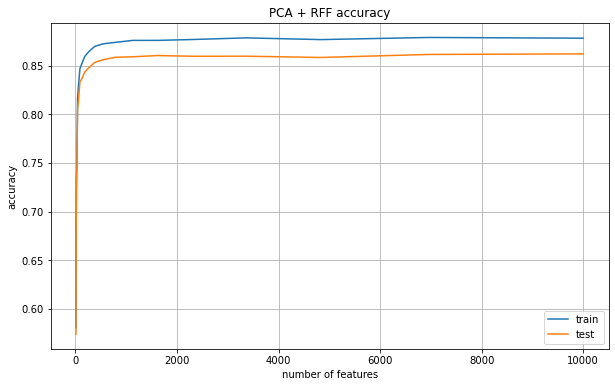

In [56]:
plt.figure(figsize=(10,6))
plt.plot([n for n in n_features], acc_train, label='train')
plt.plot([int(n) for n in n_features], acc_test, label='test')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.title('PCA + RFF accuracy')
plt.legend()
plt.grid()
plt.show()

In [75]:
print('Train accuracy values: min = %.4f, max = %.4f' % (min(acc_train), max(acc_train)))
print('Test accuracy values: min = %.4f, max = %.4f' % (min(acc_test), max(acc_test)))

Train accuracy values: min = 0.5805, max = 0.8791
Test accuracy values: min = 0.5740, max = 0.8622


*Исходя из графика выше, можно заключить следующее: с увеличением числа признаков качество модели улучшается и выходит на плато примерно при 500 признаках.*

*3. Важно ли, какую модель обучать — логистическую регрессию или SVM?*

*RFF + LogReg:*

In [76]:
rff_logreg = RFFPipeline()
start = time.time()
rff_logreg.fit(x_train, y_train)
fit_time = time.time() - start
print('RFF + Logistic regression:')
print('fitting time: %.4f s' % fit_time)

start = time.time()
rff_logreg.predict(x_test)
pred_time = time.time() - start
print('predicting time: %.4f s' % pred_time)

train_score = accuracy_score(y_train, rff_logreg.predict(x_train))
test_score = accuracy_score(y_test, rff_logreg.predict(x_test))
print('Train accuracy: %.4f' % train_score)
print('Test accuracy: %.4f' % test_score)

model_metrics = model_metrics.append({'Model' : 'RFF + LogReg', 
                      'Fitting time' : fit_time, 
                      'Predicting time' : pred_time, 
                      'Train accuracy' : train_score, 
                      'Test accuracy' : test_score}, ignore_index=True)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFF + Logistic regression:
fitting time: 39.8417 s
predicting time: 0.4303 s
Train accuracy: 0.8745
Test accuracy: 0.8550


*RFF + Linear SVM:*

In [83]:
rff_svm = RFFPipeline(classifier=LinearSVC())
start = time.time()
rff_svm.fit(x_train, y_train)
fit_time = time.time() - start
print('RFF + Linear SVM:')
print('fitting time: %.4f s' % fit_time)

start = time.time()
rff_svm.predict(x_test)
pred_time = time.time() - start
print('predicting time: %.4f s' % pred_time)

train_score = accuracy_score(y_train, rff_svm.predict(x_train))
test_score = accuracy_score(y_test, rff_svm.predict(x_test))
print('Train accuracy: %.4f' % train_score)
print('Test accuracy: %.4f' % test_score)

model_metrics = model_metrics.append({'Model' : 'RFF + LinearSVM', 
                      'Fitting time' : fit_time, 
                      'Predicting time' : pred_time, 
                      'Train accuracy' : train_score, 
                      'Test accuracy' : test_score}, ignore_index=True)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RFF + Linear SVM:
fitting time: 384.8531 s
predicting time: 0.3270 s
Train accuracy: 0.9029
Test accuracy: 0.8681


In [84]:
model_metrics

,Model,Fitting time,Predicting time,Train accuracy,Test accuracy
0,RFF default,38.937180,0.384969,0.875500,0.8596
1,LinearSVC,412.808079,0.036902,0.795917,0.7650
2,Kernel SVC,19.508461,45.844458,0.869450,0.8503
3,PCA + XGBoost,35.590056,0.100992,0.942233,0.8495
4,RFF without PCA,13.724598,0.430384,0.185417,0.1051
5,RFF + LogReg,39.841661,0.430331,0.874500,0.8550
6,RFF + LinearSVM,384.853107,0.326989,0.902867,0.8681


*RFF + LinearSVM по сравенению с RFF + LogReg обучается существенно дольше (примерно 6.5  минут для LinSVM и 40 секунд для LogReg), время применения примерно обинаковое (0.47 и 0.43 сек соответственно), но качество модели лучше (90% и 87% для RFF+LinSVM на обучающей и тестовой выборке соответсвенно; 87% и 86% для RFF+LogReg на обучающей и тестовой выборках соответсвенно)*

*Соответственно, RFF+LinSVM выйгрывает в качестве модели, но  проигрывает во времени обучения*

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [91]:
class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, ft_func = np.cos, classifier=LogisticRegression()):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Orthogonal Random Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with ORF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        ft_func, function(np.array): function to implement on w^Tx+b for new features generation
        
        classifier, linear classification model        
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.ft_func = ft_func
        self.classifier = classifier
    
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
        
        ind = np.array([random.sample(range(X.shape[0]), 2) for i in range(1000000)])
        self.sigma_sq = np.median(((X[ind[:,0]] - X[ind[:,1]]) ** 2).sum(axis=1))
        dim = X.shape[1]
        self.w = []
        self.b = []
        for i in range((self.n_features + 1) // dim):
            self.b += [np.random.uniform(-np.pi, np.pi, dim)]
            
            Q, r = np.linalg.qr(np.random.normal(0, 1, (dim, dim)))
            S = np.diagflat(np.sqrt(np.random.chisquare(dim, dim)))
            self.w += [S @ Q]
        self.b = np.array(self.b).flatten()
        self.w = np.vstack(self.w)
        
        X_new = self.ft_func((X @ self.w.T + self.b)[:, :self.n_features] / np.sqrt(self.sigma_sq))
        
        self.classifier.fit(X_new, y)
        return self
        raise NotImplementedError
        
    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)

        X_new = self.ft_func((X @ self.w.T + self.b)[:, : self.n_features] / np.sqrt(self.sigma_sq))

        if hasattr(self.classifier, 'predict_proba'):
            return self.classifier.predict_proba(X_new)
        else:
            if hasattr(self.classifier, 'decision_function'):
                return 1 / (1 + np.exp(-self.classifier.decision_function(X_new)))
        raise NotImplementedError
        
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if hasattr(self.classifier, 'classes_'):
            return self.classifier.classes_[np.argmax(self.predict_proba(X), axis=1)]
        return np.argmax(self.predict_proba(X), axis=1)
        raise NotImplementedError
        

*ORF + Logistic Regression:*

In [94]:
orf = ORFPipeline()
start = time.time()
orf.fit(x_train, y_train)
fit_time = time.time() - start
print('ORF + Logistic Regression:')
print('fitting time: %.4f s' % fit_time)

start = time.time()
orf.predict(x_test)
pred_time = time.time() - start
print('predicting time: %.4f s' % pred_time)

train_score = accuracy_score(y_train, orf.predict(x_train))
test_score = accuracy_score(y_test, orf.predict(x_test))
print('Train accuracy: %.4f' % train_score)
print('Test accuracy: %.4f' % test_score)

model_metrics = model_metrics.append({'Model' : 'ORF + LogReg', 
                      'Fitting time' : fit_time, 
                      'Predicting time' : pred_time, 
                      'Train accuracy' : train_score, 
                      'Test accuracy' : test_score}, ignore_index=True)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ORF + Logistic Regression:
fitting time: 35.9275 s
predicting time: 0.3363 s
Train accuracy: 0.8586
Test accuracy: 0.8459


*ORF + Linear SVC:*

In [95]:
orf_svc = ORFPipeline(classifier=LinearSVC())
start = time.time()
orf_svc.fit(x_train, y_train)
fit_time = time.time() - start
print('ORF + Linear SVC:')
print('fitting time: %.4f s' % fit_time)

start = time.time()
orf_svc.predict(x_test)
pred_time = time.time() - start
print('predicting time: %.4f s' % pred_time)

train_score = accuracy_score(y_train, orf_svc.predict(x_train))
test_score = accuracy_score(y_test, orf_svc.predict(x_test))
print('Train accuracy: %.4f' % train_score)
print('Test accuracy: %.4f' % test_score)

model_metrics = model_metrics.append({'Model' : 'ORF + Linear SVC', 
                      'Fitting time' : fit_time, 
                      'Predicting time' : pred_time, 
                      'Train accuracy' : train_score, 
                      'Test accuracy' : test_score}, ignore_index=True)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ORF + Linear SVC:
fitting time: 576.1892 s
predicting time: 0.3882 s
Train accuracy: 0.9045
Test accuracy: 0.8735


In [116]:
model_metrics

,Model,Fitting time,Predicting time,Train accuracy,Test accuracy
0,RFF default,38.937180,0.384969,0.875500,0.8596
1,LinearSVC,412.808079,0.036902,0.795917,0.7650
2,Kernel SVC,19.508461,45.844458,0.869450,0.8503
3,PCA + XGBoost,35.590056,0.100992,0.942233,0.8495
4,RFF without PCA,13.724598,0.430384,0.185417,0.1051
5,RFF + LogReg,39.841661,0.430331,0.874500,0.8550
6,RFF + LinearSVM,384.853107,0.326989,0.902867,0.8681
7,ORF + LogReg,35.927546,0.336264,0.858550,0.8459
8,ORF + Linear SVC,576.189248,0.388239,0.904550,0.8735


*Сначала сравним RFF/ORF + LogReg:*
*Время обучения и применения примерно одинаковое (RFF, ORF: 40 сек, 36 сек; 0.4 сек, 0.3 сек). Качество на обучающей и тестовой выборках так же не сильно отличаются (87.5% и 85.5% для RFF на обучающей и тестовой соответсвенно; 85.8% и 84.6% для ORF на обучающей и тестовой выборках соответственно)*

*RFF/ORF + LinearSVM:*
*Время обучения у ORF в 1.5 дольше, время применения моделей практически одинаковое. Качество на обучающей выборке не отличается, на тестовой выборке различия не значительные (86.8% и 87.4% для RFF и ORF соответсвенно)*

*Отсюда делаем вывод, что ORF и RFF с базывыми параметрами друг от друга мало чесм отличаются*

*Проведём аналогичный эксперемент пункту 3.2:*

In [107]:
n_features = np.logspace(2, 4, 10).astype(int)
acc_train = []
acc_test = []

for n in tqdm(n_features):
    model = ORFPipeline(n_features=n)
    model.fit(x_train, y_train)
    acc_train.append(accuracy_score(y_train, model.predict(x_train)))
    acc_test.append(accuracy_score(y_test, model.predict(x_test)))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 10%|████████▎                                                                          | 1/10 [00:15<02:21, 15.78s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

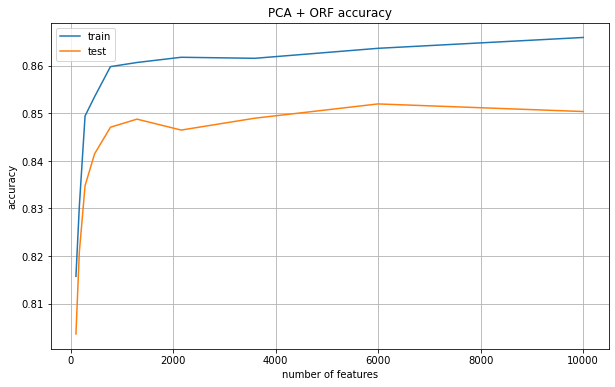

In [110]:
plt.figure(figsize=(10,6))
plt.plot([n for n in n_features], acc_train, label='train')
plt.plot([n for n in n_features], acc_test, label='test')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.title('PCA + ORF accuracy')
plt.legend()
plt.grid()
plt.show()

In [117]:
print('Train accuracy values: min = %.4f, max = %.4f' % (min(acc_train), max(acc_train)))
print('Test accuracy values: min = %.4f, max = %.4f' % (min(acc_test), max(acc_test)))

Train accuracy values: min = 0.8157, max = 0.8660
Test accuracy values: min = 0.8036, max = 0.8520


*Стоит отметить, что начиная с n_features = 6000 модель начинает переобучаться. До этого качество модели практически стабильно улудшалось*

*Аналогичн статье, исследуем точность модели в зависимости от отношения n_features / new_dim:*

In [115]:


acc_rff = []
acc_orf = []
for m in tqdm(range(50, 1050, 50)):
    rff = RFFPipeline(new_dim=50, n_features =m)
    orf = ORFPipeline(new_dim=50, n_features =m)
    rff.fit(x_train, y_train)
    orf.fit(x_train, y_train)
    acc_rff.append(accuracy_score(y_test, rff.predict(x_test)))
    acc_orf.append(accuracy_score(y_test, orf.predict(x_test)))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for al

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 40%|█████████████████████████████████▏                                                 | 8/20 [05:09<08:29, 42.47s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for al

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [11:42<04:43, 56.75s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for al

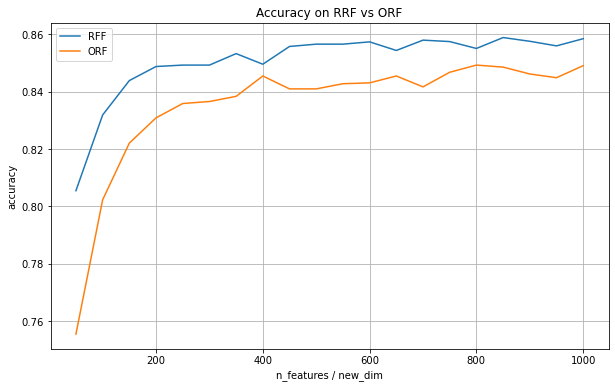

In [121]:
plt.figure(figsize=(10,6))
plt.plot(range(50, 1050, 50), acc_rff, label='RFF')
plt.plot(range(50, 1050, 50), acc_orf, label='ORF')
plt.xlabel('n_features / new_dim')
plt.ylabel('accuracy')
plt.title('Accuracy on RRF vs ORF')
plt.legend()
plt.grid()
plt.show()

*Исходя из полученных данных, можем заключить, что в среднем LogReg на ORF работает немного хуже, чем на RRF (но при увеличением отношения n_features / new_dim разница уменьшается)*

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪